In [17]:

import pandas as pd
import numpy as np
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem.snowball import GermanStemmer
#!pip install gensim
import gensim
import gensim.corpora as corpora
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, LeaveOneOut, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## Pre processing

In [2]:
nltk.download('stopwords')
stopwords_l = stopwords.words("german")

def tokenize(text):
    nltk.download('stopwords')
    stopwords_l = stopwords.words("german")
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stopwords_l]
    return tokens



def clean_text(df: pd.DataFrame, x : str):

    df[x] = df[x].str.lower()
    df[x] = df[x].replace(r"^(.*?),","",regex= True)
    # df[x] = df[x].replace(r"(viele|mit|herzliche|liebe|beste|freundliche).*grüß.*", "", regex=True) # zu breit, fuehrt teilw zu fehlern
    df[x] = df[x].replace(
    r"(mit\s+(freundlichen?|besten?)\s+grüß\w*|"
    r"freundlich\w*\s+grüß\w*|"
    r"herzlich\w*\s+grüß\w*|"
    r"lieb\w*\s+grüß\w*|"
    r"beste\s+grüß\w*)\s*.*$",
    "",
    regex=True)
    df[x] = df[x].replace(r" bitte*", "", regex=True)
    df[x] = df[x].replace(r"vielen dank.*","",regex = True)
    df[x] = df[x].replace(r'[^\s\w]+','',regex = True)

    return df


def remove_stopwords_from_series(text):
    words = text.split()
    words_filtered = [w for w in words if w not in stopwords_l]
    return " ".join(words_filtered)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_excel("20250602_Anfragen_Sample.xlsx")
df_clean = clean_text(df, "Kundenanfrage")
df_clean["Kundenanfrage"] = df_clean["Kundenanfrage"].apply(remove_stopwords_from_series)
df_clean["tokens"] = df_clean["Kundenanfrage"].str.split()
id2word = corpora.Dictionary(df_clean["tokens"])
texts = df_clean["tokens"]
corpus = [id2word.doc2bow(text) for text in texts]

In [5]:
# Initialize the German stemmer
stemmer = GermanStemmer()

# Apply stemming to each token in the "Kundenanfrage" column
df_clean["stemmed"] = df["Kundenanfrage"].apply(lambda tokens: [stemmer.stem(token) for token in tokens])


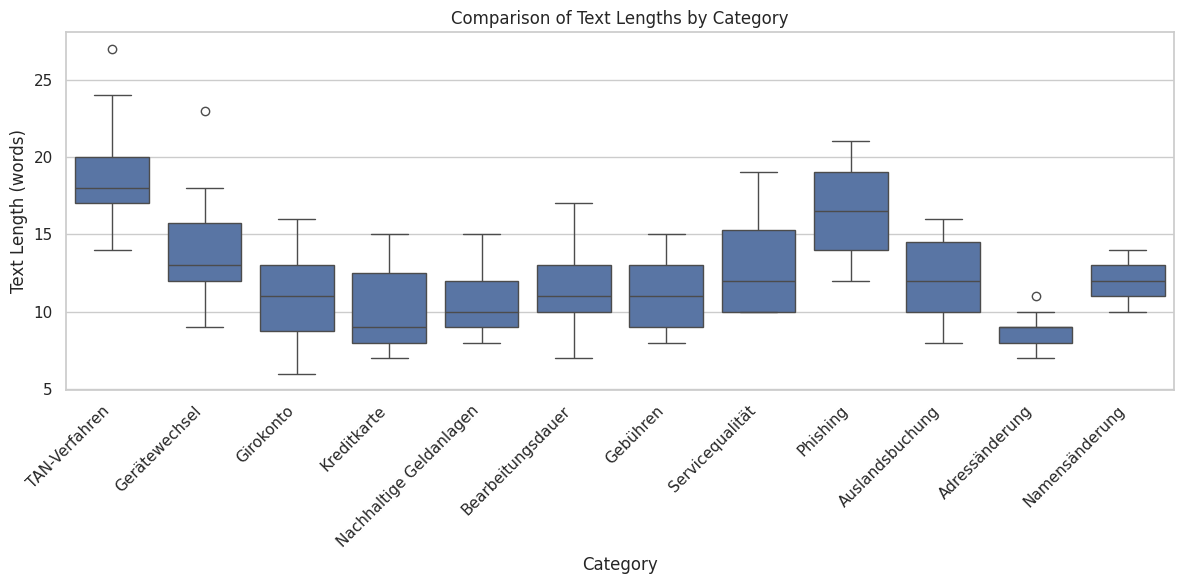

In [43]:
# Calculate text length (number of words)
df_clean["text_length"] = df_clean["Kundenanfrage"].apply(lambda x: len(str(x).split()))

# Set plot style (optional)
sns.set(style="whitegrid")

# Draw a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x="Unterkategorie2", y="text_length")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Category")
plt.ylabel("Text Length (words)")
plt.title("Comparison of Text Lengths by Category")
plt.tight_layout()
plt.show()

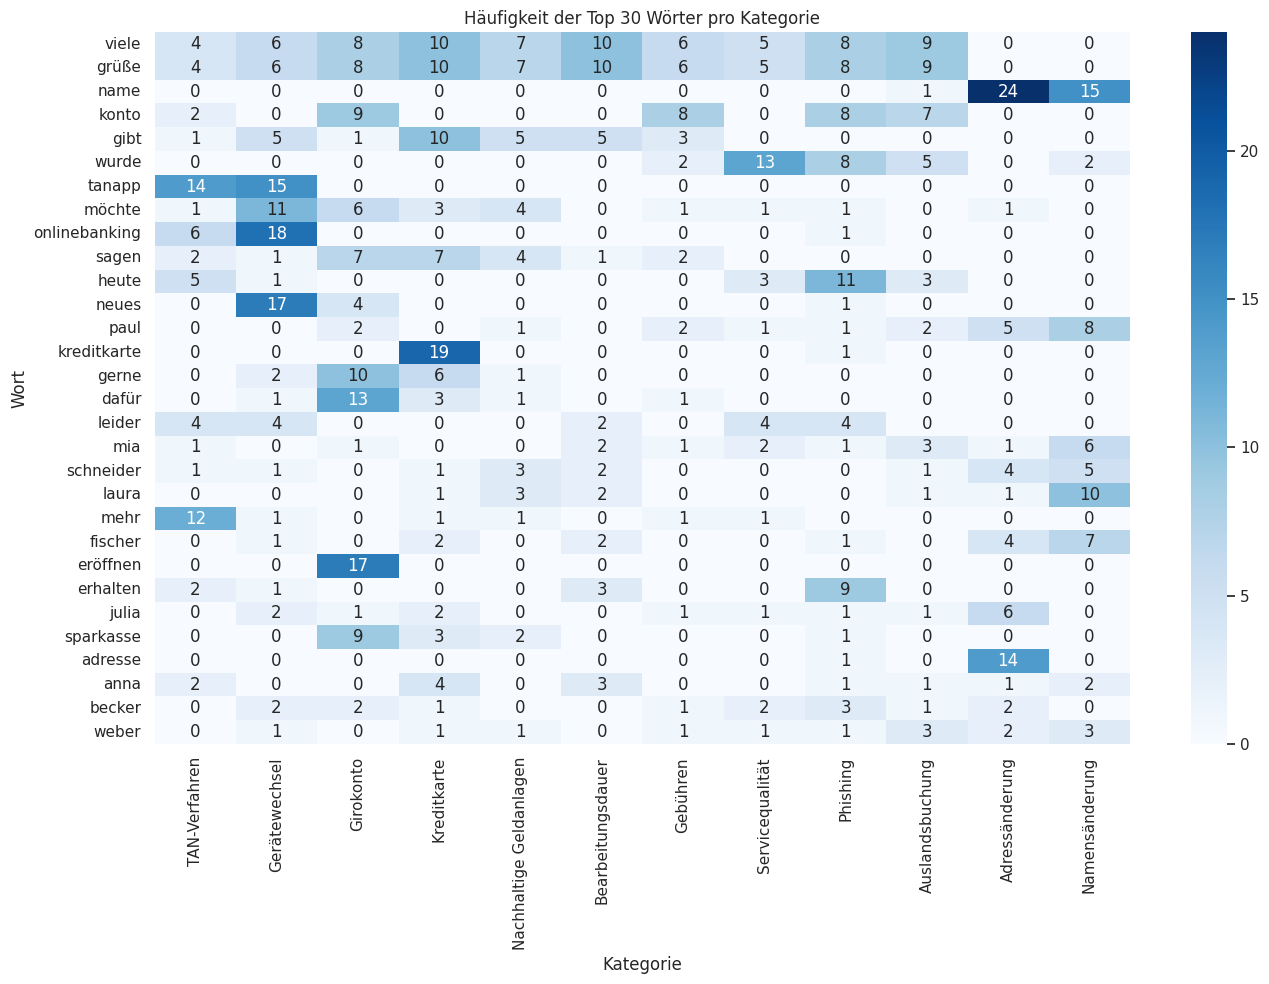

In [7]:
# 1. Count all tokens
all_tokens = df_clean["tokens"].explode()
word_counts = Counter(all_tokens)

# 2. Get the top 30 most frequent words
top_30_words = [word for word, _ in word_counts.most_common(30)]

# 3. Prepare category-word count matrix
categories = df_clean["Unterkategorie2"].unique()
heatmap_data = pd.DataFrame(0, index=top_30_words, columns=categories)

# 4. Fill the matrix: count word occurrences per category
for _, row in df_clean.iterrows():
    tokens = row["tokens"]
    category = row["Unterkategorie2"]
    for token in tokens:
        if token in top_30_words:
            heatmap_data.at[token, category] += 1

# 5. Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title("Frequency of Top 30 Words per Category")
plt.xlabel("Category")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

In [8]:
# Group all customer requests by category and combine them into a single text per category
df_group = pd.DataFrame(df_clean.groupby("Unterkategorie2")["Kundenanfrage"].agg(lambda x: " ".join(x)))

Adressänderung


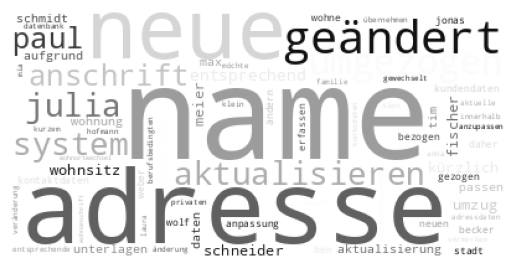

Auslandsbuchung


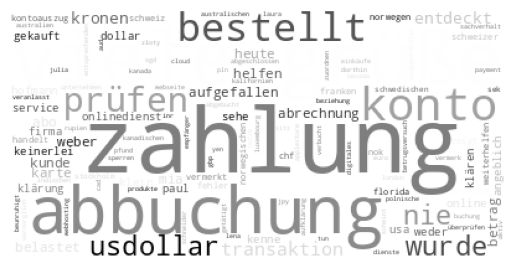

Bearbeitungsdauer


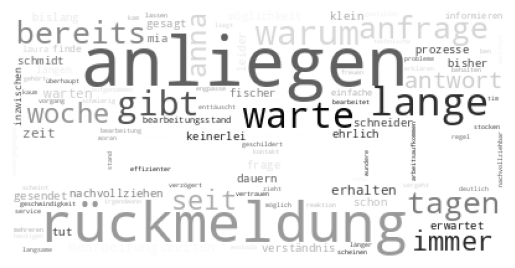

Gebühren


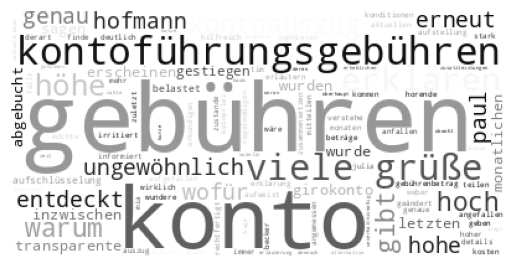

Gerätewechsel


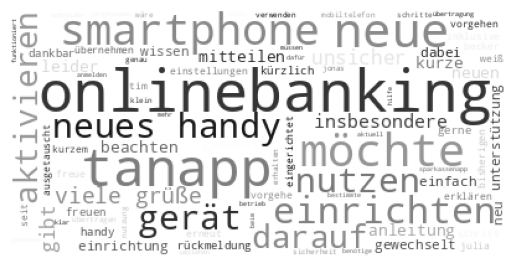

Girokonto


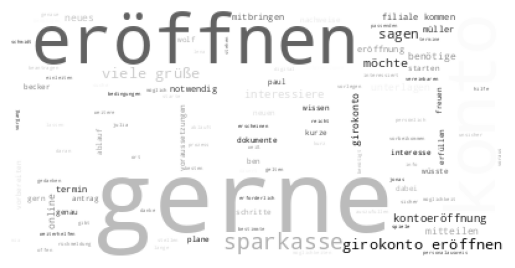

Kreditkarte


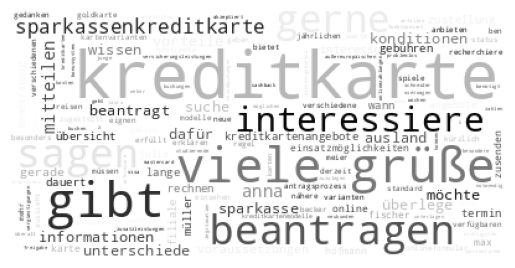

Nachhaltige Geldanlagen


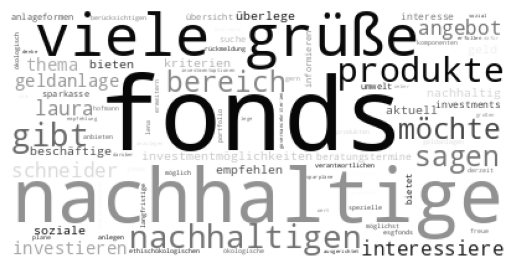

Namensänderung


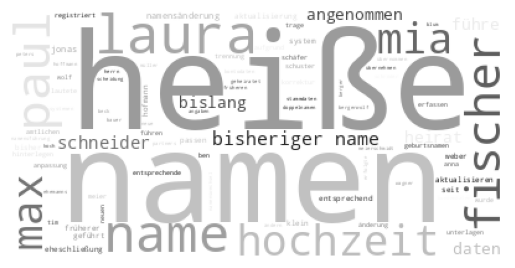

Phishing


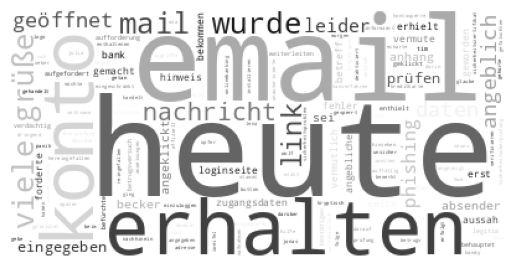

Servicequalität


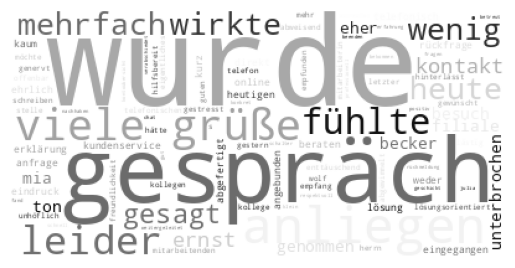

TAN-Verfahren


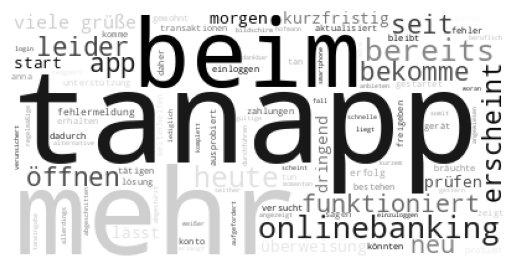

In [44]:
# Create a dictionary to store word clouds for each category
wordcloud_dic = {}

# Generate a word cloud for each category
for index, row in df_group.iterrows():
    wc = WordCloud(background_color='white', colormap='binary').generate(row["Kundenanfrage"])
    wordcloud_dic[index] = wc

# Display the word clouds
for category, wc in wordcloud_dic.items():
    print(category)
    plt.axis("off")
    plt.imshow(wc)
    plt.show()

## LDA

### LDA with Random Forrest

In [36]:
df_clean["encoded_categories"] = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])
n_topics = [3,6,9,12]
alphas = [0.75,1]
betas = [0.1,0.5]
parameters_RF = {'max_depth':[25],
                 'max_samples':[0.6],
                 'max_features':[9]}
df_score = pd.DataFrame({'alpha':[],'beta':[],'n_topics' :[],'max_depth' : [], 'max_features':[], 'max_samples':[],'accuracy':[]})

for a in alphas:
    for b in betas:
        for n in n_topics:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=n,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha = a,
                                                eta = b,
                                                per_word_topics=False)
            topics = lda_model.print_topics(num_words=10)
            t = lda_model.get_document_topics(corpus,minimum_probability=0)
            columns = []
            for i in range(0,n):
                df[f"topic_{i}"] = [t[d][i][1] for d in range(0,len(t))]
                columns.append(f"topic_{i}")
            X = df[columns]
            y = df['encoded_categories']
            X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

            #Random Forest
            RF = RandomForestClassifier(random_state=42)

            #Hyperparameter Tuning ausführen
            CV_RF = GridSearchCV(RF,
                                parameters_RF,
                                scoring = 'accuracy',
                                cv = 10)

            #Mit dem Trainingsatz trainieren
            CV_RF.fit(X_train,y_train)
            print(CV_RF.best_score_)
            #Feature importances anzeigen
            print(CV_RF.best_estimator_.feature_importances_)
            y_pred_RF = CV_RF.predict(X_test)
            #Accuracy-Wert für den Testsatz speichern
            RF_score = accuracy_score(y_test,y_pred_RF)
            df_score2 = pd.DataFrame({'alpha':[a],'beta':[b], 'n_topics' : [n],
                                    'max_depth' : [CV_RF.best_estimator_.get_params()["max_depth"]],
                                    'max_features':[CV_RF.best_estimator_.get_params()["max_features"]],
                                    'max_samples':[CV_RF.best_estimator_.get_params()["max_samples"]],
                                    'accuracy':[RF_score]})
            df_score = pd.concat([df_score,df_score2],axis = 0)


print(RF_score)



0.2505263157894737
[0.40389295 0.30242219 0.29368486]
0.4671052631578947
[0.17417781 0.21466117 0.20195559 0.15512233 0.13282797 0.12125513]
0.5781578947368422
[0.05753308 0.15545815 0.05526516 0.0999633  0.1504301  0.09172097
 0.13725728 0.0770667  0.17530526]
0.6434210526315789
[0.0668288  0.10717301 0.0538311  0.07910915 0.11466796 0.08306392
 0.13755758 0.05360118 0.12607431 0.04493173 0.0705254  0.06263586]
0.3928947368421053
[0.34415914 0.28875876 0.3670821 ]
0.5628947368421053
[0.17461546 0.22653869 0.16003549 0.16305477 0.15540732 0.12034827]
0.6089473684210527
[0.06976843 0.18414198 0.02829364 0.07044397 0.11658585 0.19549398
 0.18056761 0.09023589 0.06446865]
0.6289473684210527
[0.02135938 0.15183954 0.02158871 0.02591533 0.10208979 0.07803864
 0.16983186 0.11596152 0.19473155 0.02354824 0.0644326  0.03066284]
0.3163157894736842
[0.35543266 0.30349117 0.34107617]
0.4873684210526316
[0.17610658 0.22668706 0.21503922 0.13526166 0.13370246 0.11320301]
0.638421052631579
[0.081769

In [12]:
print(RF_score)



0.68


### LDA with Naive Bayes

In [34]:
# Model LDA with Naive Bayes

df_clean["encoded_categories"] = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])

n_topics = [3, 6, 9, 12]
alphas = [0.75, 1]
betas = [0.1, 0.5]

df_score = pd.DataFrame({'alpha': [], 'beta': [], 'n_topics': [], 'accuracy': []})

for a in alphas:
    for b in betas:
        for n in n_topics:
            lda_model = gensim.models.ldamodel.LdaModel(
                corpus=corpus,
                id2word=id2word,
                num_topics=n,
                random_state=100,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha=a,
                eta=b,
                per_word_topics=False
            )

            t = lda_model.get_document_topics(corpus, minimum_probability=0)
            columns = []
            for i in range(n):
                df[f"topic_{i}"] = [t[d][i][1] for d in range(len(t))]
                columns.append(f"topic_{i}")

            X = df[columns]
            y = df['encoded_categories']

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

            # Naive Bayes
            NB = MultinomialNB()
            NB.fit(X_train, y_train)
            y_pred_NB = NB.predict(X_test)
            NB_score = accuracy_score(y_test, y_pred_NB)

            df_score2 = pd.DataFrame({
                'alpha': [a],
                'beta': [b],
                'n_topics': [n],
                'accuracy': [NB_score]
            })

            df_score = pd.concat([df_score, df_score2], axis=0, ignore_index=True)

# Show best result
best_result = df_score.loc[df_score['accuracy'].idxmax()]
print("Best configuration:\n", best_result)

Best configuration:
 alpha       0.75
beta        0.50
n_topics    6.00
accuracy    0.42
Name: 5, dtype: float64


## TF-IDF Vectorization

In [13]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
vectorizer = TfidfVectorizer(
    max_features=461,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,            # ignore rare words (must be in at least 2 documents)
    max_df=0.9           # ignore too common (if term is in more than 90% of documents)
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
y_encoded = LabelEncoder().fit_transform(y)

# Feature-Namen aus dem Vectorizer
feature_names = vectorizer.get_feature_names_out()

# Funktion: Top-N Wörter pro Kategorie
def top_words_per_category(X, y, feature_names, top_n=10):
    categories = np.unique(y)
    rows = []
    for cat in categories:
        mask = (y == cat)
        # Mittelwert der TF-IDF-Werte pro Wort in dieser Kategorie
        tfidf_means = np.asarray(X[mask].mean(axis=0)).flatten()
        top_idx = tfidf_means.argsort()[::-1][:top_n]
        for i in top_idx:
            rows.append({
                "Kategorie": cat,
                "Wort": feature_names[i],
                "TF-IDF Mittelwert": tfidf_means[i]
            })
    return pd.DataFrame(rows)

# DataFrame mit Top-Wörtern
df_top_words = top_words_per_category(X, y.values, feature_names, top_n=10)

# Optional: Nach Kategorie und Score sortieren
df_top_words = df_top_words.sort_values(["Kategorie", "TF-IDF Mittelwert"], ascending=[True, False])

df_top_words

,Kategorie,Wort,TF-IDF Mittelwert
0,Adressänderung,name,0.206328
1,Adressänderung,adresse,0.154385
2,Adressänderung,neue,0.106045
3,Adressänderung,geändert,0.098771
4,Adressänderung,umgezogen,0.094486
5,Adressänderung,name julia,0.085703
6,Adressänderung,aktualisieren,0.084624
7,Adressänderung,system,0.076341
8,Adressänderung,adresse system,0.071147
9,Adressänderung,julia,0.070219


### TF_IDF with NN

In [45]:
# Feature extraction using TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"]).toarray()

# Prepare the target variable
le = LabelEncoder()
y = le.fit_transform(df_clean["Unterkategorie2"])
y_cat = to_categorical(y)  # One-hot encoding for Keras

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_cat.shape[1], activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluate the model on the test set
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.0911 - loss: 2.4847 - val_accuracy: 0.1500 - val_loss: 2.4828
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3679 - loss: 2.4175 - val_accuracy: 0.2500 - val_loss: 2.4606
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5101 - loss: 2.3425 - val_accuracy: 0.2500 - val_loss: 2.4291
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5287 - loss: 2.2589 - val_accuracy: 0.2500 - val_loss: 2.3818
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6075 - loss: 2.1012 - val_accuracy: 0.2000 - val_loss: 2.3196
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6617 - loss: 1.8720 - val_accuracy: 0.4000 - val_loss: 2.2154
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8129 - loss: 1.5878 - val_accuracy: 0.4500 - val_loss: 2.0665
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8537 - loss: 1.3027 - val_accuracy: 0.5000 - val_loss: 1.8729
Epoch 9/15

### TF-IDF with Logistic Regression

In [18]:


# Daten
X = df_clean["Kundenanfrage"].astype(str)
y = df_clean["Unterkategorie2"].astype(str)

# Pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        min_df=0.01,
        max_df=0.8
    )),
    ("lr", LogisticRegression(max_iter=2000))
])

# Hyperparameter-Grid (für den Step-Namen "lr" mit Präfix lr__)
param_grid1 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l1','l2'],
    'lr__solver': ['lbfgs', 'liblinear'],
    'lr__class_weight': [None, 'balanced'],
    'lr__multi_class': ['ovr']
}

param_grid2 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l1','l2'],
    'lr__solver': ['liblinear'],
    'lr__class_weight': [None, 'balanced'],
    'lr__multi_class': ['ovr']
}

param_grid3 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs'],
    'lr__class_weight': [None, 'balanced'],
    'lr__multi_class': ['ovr']
}

param_grid4 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['newton-cg'],
    'lr__class_weight': [None, 'balanced']
}

# LOO-CV
loo = LeaveOneOut()

# GridSearch mit LOO (dauert länger, aber bei n≈250 okay)
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid3,
    cv=loo,
    scoring='f1_macro',
    n_jobs=-1
)
grid.fit(X, y)

best_lr = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("LOO mean accuracy (CV best_score_):", grid.best_score_)

# (Optional) LOO-Vorhersagen für jeden Punkt – für Report/Metriken pro Klasse
y_pred_loo = cross_val_predict(best_lr, X, y, cv=loo, n_jobs=-1)
print("\nClassification Report (LOO):")
print(classification_report(y, y_pred_loo))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__multi_class': 'ovr', 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
LOO mean accuracy (CV best_score_): 0.9678714859437751

Classification Report (LOO):
                         precision    recall  f1-score   support

         Adressänderung       0.92      0.96      0.94        24
        Auslandsbuchung       1.00      1.00      1.00        23
      Bearbeitungsdauer       0.91      0.91      0.91        22
               Gebühren       0.89      1.00      0.94        17
          Gerätewechsel       1.00      1.00      1.00        22
              Girokonto       1.00      1.00      1.00        24
            Kreditkarte       1.00      0.96      0.98        27
Nachhaltige Geldanlagen       0.95      0.95      0.95        19
         Namensänderung       0.95      0.95      0.95        20
               Phishing       1.00      0.95      0.97        20
        Servicequalität       1.00      0.94      0.97        16
  

In [19]:
# DataFrame mit echten und vorhergesagten Labels
df_results = pd.DataFrame({
    "Text": X,
    "True Label": y,
    "Predicted Label": y_pred_loo
})

# Nur falsch klassifizierte Zeilen
df_misclassified = df_results[df_results["True Label"] != df_results["Predicted Label"]]

print(f"Falsch klassifiziert: {len(df_misclassified)} von {len(df_results)} Beobachtungen")
df_misclassified

Falsch klassifiziert: 8 von 249 Beobachtungen


,Text,True Label,Predicted Label
74,wüsste gerne sparkassenkreditkarte außereuropä...,Kreditkarte,Gebühren
96,denke darüber geld nachhaltig anzulegen empfeh...,Nachhaltige Geldanlagen,Bearbeitungsdauer
111,vorgang scheint stocken geraten erklären wesha...,Bearbeitungsdauer,Gebühren
128,verständnis betrieb hätte zumindest zwischenme...,Bearbeitungsdauer,Nachhaltige Geldanlagen
148,letzter besuch filiale leider enttäuschend mit...,Servicequalität,Bearbeitungsdauer
169,versehentlich zugangsdaten gefälschten loginse...,Phishing,Adressänderung
224,name laura hofmann wohnortwechsel aktualisiere...,Adressänderung,Namensänderung
230,name bisher anna meier geheiratet trage namen ...,Namensänderung,Adressänderung


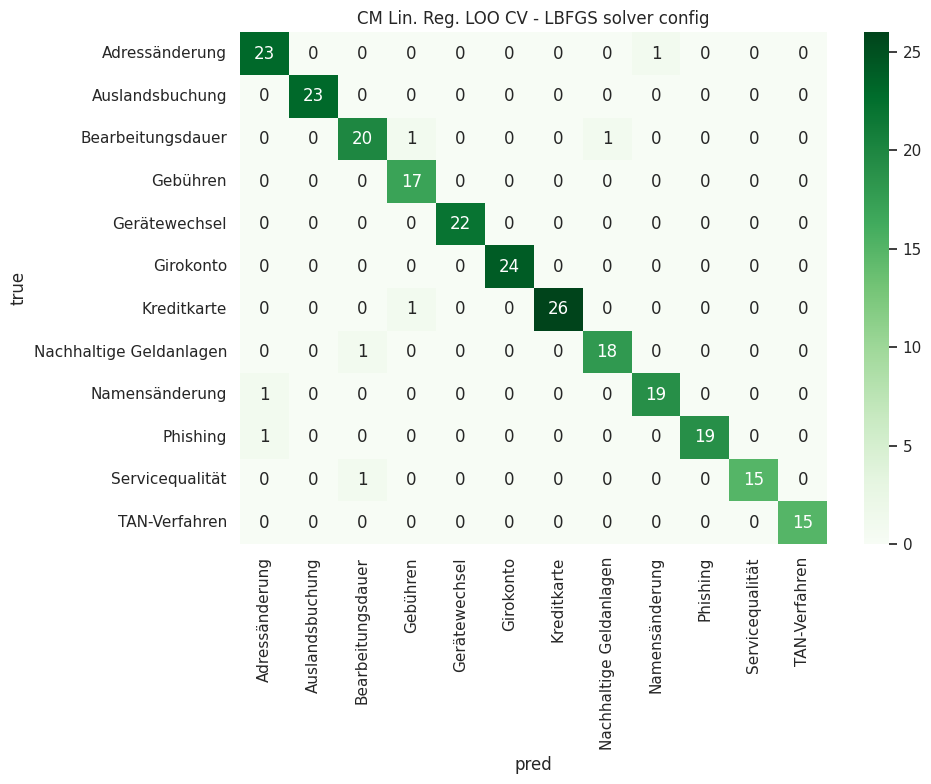

In [20]:


# Konfusionsmatrix berechnen
labels = sorted(y.unique())  # Original-Labels in fester Reihenfolge
cm = confusion_matrix(y, y_pred_loo, labels=labels)

# Als Heatmap darstellen
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("pred")
plt.ylabel("true")
plt.title("CM Lin. Reg. LOO CV - LBFGS solver config")
plt.tight_layout()
plt.show()

In [21]:


# Pipeline erneut fitten (falls noch nicht geschehen)
best_lr.fit(X, y)

# Zugriff auf den Vektorizer
vectorizer = best_lr.named_steps["tfidf"]
feature_names = np.array(vectorizer.get_feature_names_out())

# Zugriff auf die Logistic Regression
lr_model = best_lr.named_steps["lr"]

# Für jede Klasse Top-Wörter ausgeben
for class_idx, class_label in enumerate(lr_model.classes_):
    coefs = lr_model.coef_[class_idx]
    top_pos_idx = np.argsort(coefs)[-10:]     # größte positive Koeffizienten
    top_neg_idx = np.argsort(coefs)[:10]      # größte negative Koeffizienten

    print(f"\n=== Klasse: {class_label} ===")
    print("Top positive Wörter:")
    for i in reversed(top_pos_idx):
        print(f"{feature_names[i]:<20} {coefs[i]:.4f}")

    print("\nTop negative Wörter:")
    for i in top_neg_idx:
        print(f"{feature_names[i]:<20} {coefs[i]:.4f}")


=== Klasse: Adressänderung ===
Top positive Wörter:
name                 3.3905
adresse              2.2973
geändert             1.8888
neue                 1.6003
umgezogen            1.5734
aktualisieren        1.3912
anschrift            1.3884
name julia           1.3069
entsprechend         1.2703
adresse system       1.1443

Top negative Wörter:
viele                -0.7132
viele grüße          -0.7132
grüße                -0.7132
wurde                -0.5542
heiße                -0.5468
konto                -0.5112
gibt                 -0.5052
namen                -0.4873
sagen                -0.4449
kreditkarte          -0.4237

=== Klasse: Auslandsbuchung ===
Top positive Wörter:
abbuchung            2.5925
zahlung              2.5597
bestellt             2.2087
transaktion          2.1750
usdollar             1.7793
kronen               1.7587
entdeckt             1.4075
anbieter             1.3830
konto wurde          1.3583
nie                  1.3554

Top negative Wörter:

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [22]:


# Textdaten und Labels vorbereiten
texts = df_clean["Kundenanfrage"]
labels = df_clean["Unterkategorie2"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# TF-IDF-Vektorisierung
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)
X = vectorizer.fit_transform(texts)

# Leave-One-Out CV vorbereiten
loo = LeaveOneOut()
y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LogisticRegression(
        C=1,
        penalty='l2',
        solver='liblinear',
        max_iter=1000
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    y_true.append(y_test[0])
    y_pred.append(pred[0])

# Ergebnis evaluieren
acc = accuracy_score(y_true, y_pred)
print(f"Leave-One-Out Accuracy: {acc:.4f}")

Leave-One-Out Accuracy: 0.9438


In [23]:
# evaluation ueber gesamten datensatz

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_lr, X, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
print("Cross-Val Accuracies:", scores)
print("Mean CV-Accuracy:", scores.mean())

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line 1376, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line 1263, in _count_vocab
    for feature in analyze(doc):
                   ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line 104, in _analyze
    doc = preprocessor(doc)
          ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line 62, in _preprocess
    doc = doc.lower()
          ^^^^^^^^^
AttributeError: 'csr_matrix' object has no attribute 'lower'


In [24]:
# confusion matrix fuer testset

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [1, 249]

### TF-IDF with XG Boost

In [25]:
# TF-IDF Vectorization with XG Boost
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,            # ignore rare words
    max_df=0.9           # ignore too common
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
y_encoded = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'use_label_encoder': [False],
    'eval_metric': ['mlogloss']  # Avoids warning
}

# Grid search
xgb = XGBClassifier(random_state=42, verbosity=0)
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best estimator
best_xgb = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict & evaluate
y_pred_xg = best_xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred_xg)

print("Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xg))

Best parameters: {'colsample_bytree': 1, 'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1, 'use_label_encoder': False}
Accuracy: 0.8

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.82      0.90      0.86        10
           2       0.83      0.83      0.83         6
           3       0.50      1.00      0.67         2
           4       1.00      0.62      0.77         8
           5       1.00      1.00      1.00         4
           6       0.67      0.67      0.67         3
           7       1.00      0.67      0.80         3
           8       0.67      1.00      0.80         2
           9       1.00      0.60      0.75         5
          10       0.50      0.50      0.50         2
          11       0.60      1.00      0.75         3

    accuracy                           0.80        50
   macro avg       0.80      0.82

### TF-IDF  with Support Vector Machiene

In [49]:
# TF-IDF Vectorization with Support Vector Machiene
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,
    max_df=0.8
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced'],
    'gamma': ['scale', 'auto']
}

# Grid search
svc = SVC()
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best estimator
best_svm = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict & evaluate
y_pred_SVM = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred_SVM)

print("Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_SVM))

Best parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        10
           2       1.00      0.83      0.91         6
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3

    accuracy                           0.98        50
   macro avg       0.97      0.99      0.98        50
weighted avg       0.99      0.98      0.98        50



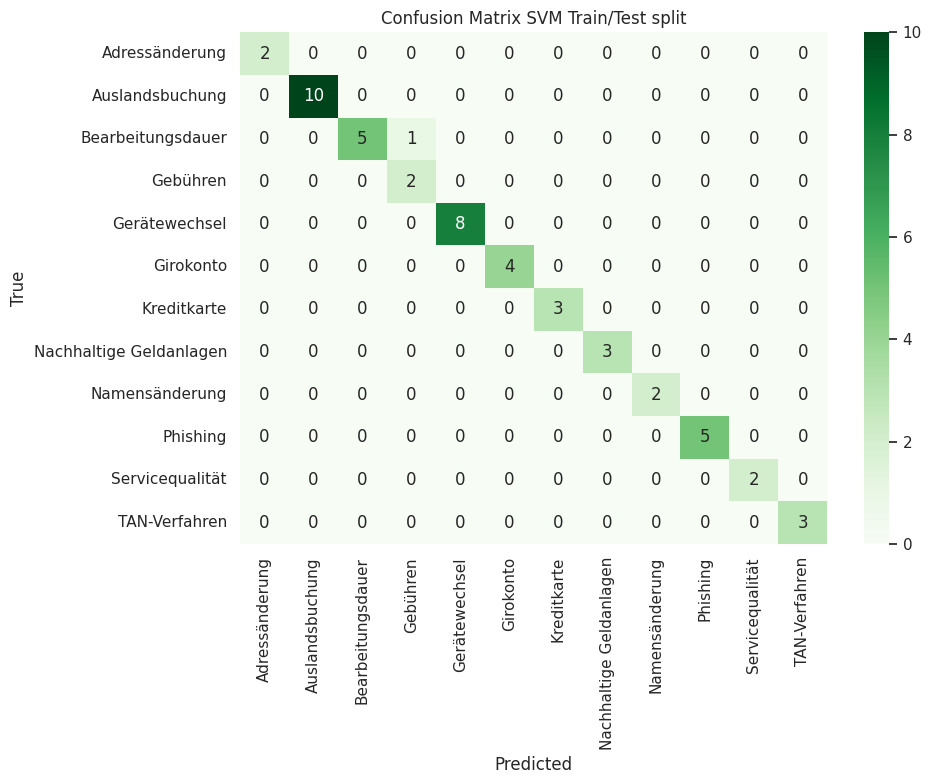

In [27]:
# Konfusionsmatrix berechnen für SVM
labels = sorted(set(y_test))
category_labels = encoder.inverse_transform(labels)

cm = confusion_matrix(y_test, y_pred_SVM, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix SVM Train/Test split")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Best parameters (SVM LOO): {'svc__C': 10, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
LOO mean accuracy (SVM): 0.9598393574297188

Classification Report (SVM LOO):
                         precision    recall  f1-score   support

         Adressänderung       0.96      0.96      0.96        24
        Auslandsbuchung       1.00      0.96      0.98        23
      Bearbeitungsdauer       0.91      0.91      0.91        22
               Gebühren       0.94      1.00      0.97        17
          Gerätewechsel       1.00      0.95      0.98        22
              Girokonto       0.96      1.00      0.98        24
            Kreditkarte       0.96      1.00      0.98        27
Nachhaltige Geldanlagen       0.94      0.89      0.92        19
         Namensänderung       0.95      1.00      0.98        20
               Phishing       1.00      0.90      0.95        20
        Servicequalität       0.88      0.94      0.91        16
          TAN-Verfahren 

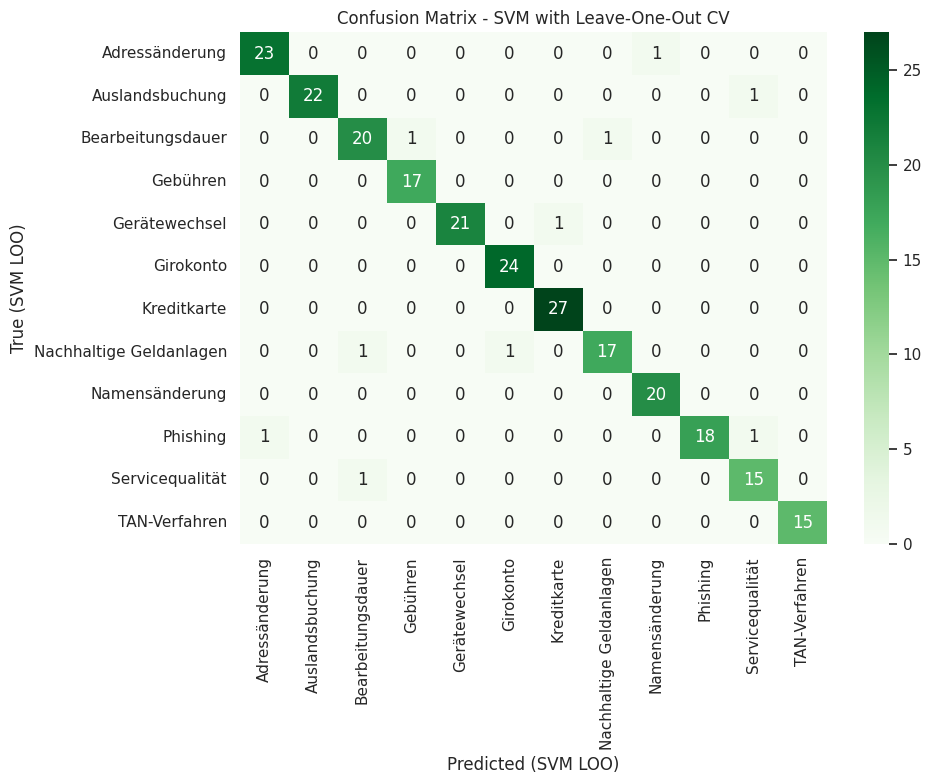

In [47]:
# Braucht ca. 4min
# Data preparation
X_text = df_clean["Kundenanfrage"].astype(str)  # Feature: customer queries
y_labels = df_clean["Unterkategorie2"].astype(str)  # Target: subcategories

# Pipeline: TF-IDF vectorization + SVM classifier
svm_loo_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        min_df=0.01,
        max_df=0.8
    )),
    ("svc", SVC())
])

# Hyperparameter grid for SVM with Leave-One-Out CV
svm_loo_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__class_weight': [None, 'balanced'],
    'svc__gamma': ['scale', 'auto']
}

# Leave-One-Out cross-validation setup
loo_cv = LeaveOneOut()

# GridSearchCV using LOO cross-validation
svm_loo_grid = GridSearchCV(
    estimator=svm_loo_pipeline,
    param_grid=svm_loo_param_grid,
    cv=loo_cv,
    scoring='accuracy',
    n_jobs=-1
)
svm_loo_grid.fit(X_text, y_labels)

# Best SVM model found with LOO CV
best_svm_loo = svm_loo_grid.best_estimator_
print("Best parameters (SVM LOO):", svm_loo_grid.best_params_)
print("LOO mean accuracy (SVM):", svm_loo_grid.best_score_)

# Obtain Leave-One-Out predictions for all samples
y_pred_svm_loo = cross_val_predict(best_svm_loo, X_text, y_labels, cv=loo_cv, n_jobs=-1)

# Classification report for SVM with LOO CV
print("\nClassification Report (SVM LOO):")
print(classification_report(y_labels, y_pred_svm_loo))

# Confusion matrix for SVM with LOO CV
svm_loo_labels = sorted(y_labels.unique())
cm_svm_loo = confusion_matrix(y_labels, y_pred_svm_loo, labels=svm_loo_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm_loo, annot=True, fmt='d', cmap='Greens',
            xticklabels=svm_loo_labels, yticklabels=svm_loo_labels)
plt.xlabel("Predicted (SVM LOO)")
plt.ylabel("True (SVM LOO)")
plt.title("Confusion Matrix - SVM with Leave-One-Out CV")
plt.tight_layout()
plt.show()

In [48]:
# Create a DataFrame with true and predicted labels
df_results = pd.DataFrame({
    "Text": X_text,
    "True Label": y_labels,
    "Predicted Label": y_pred_svm_loo
})

# Filter only the misclassified rows
df_misclassified = df_results[df_results["True Label"] != df_results["Predicted Label"]]

# Print the number of misclassified samples
print(f"Misclassified: {len(df_misclassified)} out of {len(df_results)} observations")

# Display the misclassified samples
df_misclassified

Misclassified: 10 out of 249 observations


,Text,True Label,Predicted Label
17,neues mobiltelefon gerne wissen nutzung sparka...,Gerätewechsel,Kreditkarte
92,interesse ökologisch verantwortlichen investme...,Nachhaltige Geldanlagen,Girokonto
96,denke darüber geld nachhaltig anzulegen empfeh...,Nachhaltige Geldanlagen,Bearbeitungsdauer
111,vorgang scheint stocken geraten erklären wesha...,Bearbeitungsdauer,Gebühren
128,verständnis betrieb hätte zumindest zwischenme...,Bearbeitungsdauer,Nachhaltige Geldanlagen
148,letzter besuch filiale leider enttäuschend mit...,Servicequalität,Bearbeitungsdauer
169,versehentlich zugangsdaten gefälschten loginse...,Phishing,Adressänderung
179,facebook anzeige gesehen behauptet wurde könne...,Phishing,Servicequalität
186,heute wurde betrag usdollar cloud services abg...,Auslandsbuchung,Servicequalität
224,name laura hofmann wohnortwechsel aktualisiere...,Adressänderung,Namensänderung


In [30]:

# LinearSVC pipeline
svm_loo_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        min_df=0.01,
        max_df=0.8
    )),
    ("svc", LinearSVC(class_weight='balanced', max_iter=5000))
])

svm_loo_pipeline.fit(X_text, y_labels)

# Access dense coefficients
svm_model = svm_loo_pipeline.named_steps["svc"]
coefs = svm_model.coef_  # now a dense np.array
feature_names = np.array(svm_loo_pipeline.named_steps["tfidf"].get_feature_names_out())

# Top features per class
for class_idx, class_label in enumerate(svm_model.classes_):
    top_pos_idx = np.argsort(coefs[class_idx])[-10:]
    top_neg_idx = np.argsort(coefs[class_idx])[:10]

    print(f"\n=== Klasse: {class_label} ===")
    print("Top positive Wörter:")
    for i in reversed(top_pos_idx):
        print(f"{feature_names[i]:<20} {coefs[class_idx][i]:.4f}")

    print("\nTop negative Wörter:")
    for i in top_neg_idx:
        print(f"{feature_names[i]:<20} {coefs[class_idx][i]:.4f}")




=== Klasse: Adressänderung ===
Top positive Wörter:
name                 1.5824
geändert             1.1136
umgezogen            0.9857
neue                 0.7944
anschrift            0.7720
adresse system       0.7639
aktualisieren        0.7380
adresse geändert     0.6897
system               0.6371
entsprechend         0.6222

Top negative Wörter:
heiße                -0.7616
namen                -0.6308
hochzeit             -0.4390
bisheriger           -0.4044
bisheriger name      -0.4044
bisher               -0.3888
angenommen           -0.3884
führe                -0.3668
girokonto            -0.3305
namensänderung       -0.3170

=== Klasse: Auslandsbuchung ===
Top positive Wörter:
zahlung              1.5143
abbuchung            1.4454
bestellt             1.2972
transaktion          1.2412
kronen               1.0250
usdollar             0.9953
betrag               0.9587
konto wurde          0.9163
entdeckt             0.7629
anbieter             0.7345

Top negative Wörter:

## BERT

In [32]:
# 1. Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Compact and fast

# 2. BERT embeddings
X = model.encode(df_clean["Kundenanfrage"].tolist(), show_progress_bar=True)

# 3. Encode labels
y = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Set parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# 6. Grid Search with CV
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 7. Fit model
grid.fit(X_train, y_train)

# 8. Evaluate
print("🔍 Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_

y_pred_BERT = best_rf.predict(X_test)
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred_BERT))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_BERT))

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}

✅ Accuracy: 0.72

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       1.00      0.30      0.46        10
           2       1.00      0.67      0.80         6
           3       0.25      0.50      0.33         2
           4       0.89      1.00      0.94         8
           5       1.00      1.00      1.00         4
           6       0.60      1.00      0.75         3
           7       0.50      0.67      0.57         3
           8       1.00      1.00      1.00         2
           9       0.80      0.80      0.80         5
          10       0.67      1.00      0.80         2
          11       1.00      0.33      0.50         3

    accuracy                           0.72        50
   macro avg       0.75  

## Model comparison

In [37]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
# Create a list to store results
results = []

# Example: LDA with Random Forrest
LDA_RF_acc = accuracy_score(y_test, y_pred_RF)
LDA_RF_f1 = f1_score(y_test, y_pred_RF, average='weighted')
results.append({
    "Model": "LDA with Random Forrest",
    "Accuracy": LDA_RF_acc,
    "F1 Score": LDA_RF_f1
})

# Example: LDA with Naive Bayes
LDA_NB_acc = accuracy_score(y_test, y_pred_NB)
LDA_NB_f1 = f1_score(y_test, y_pred_NB, average='weighted')
results.append({
    "Model": "LDA with Naive Bayes",
    "Accuracy": LDA_NB_acc,
    "F1 Score": LDA_NB_f1
})

# Example: Logistic Regression with TF_IDF
LR_acc = accuracy_score(y_labels, y_pred_loo)
LR_f1 = f1_score(y_labels, y_pred_loo, average='weighted')
results.append({
    "Model": "Logistic Regression with TF-IDF",
    "Accuracy": LR_acc,
    "F1 Score": LR_f1
})

# Example: XgBoost with TF_IDF
xg_acc = accuracy_score(y_test, y_pred_xg)
xg_f1 = f1_score(y_test, y_pred_xg, average='weighted')
results.append({
    "Model": "XgBoost with TF-IDF",
    "Accuracy": xg_acc,
    "F1 Score": xg_f1
})

# Example: SVM with TF_IDF
svm_acc = accuracy_score(y_test, y_pred_SVM)
svm_f1 = f1_score(y_test, y_pred_SVM, average='weighted')
results.append({
    "Model": "SVM with TF_IDF",
    "Accuracy": svm_acc,
    "F1 Score": svm_f1
})

# Example: SVM with with TF_IDF and LOO
svm_LOO_acc = accuracy_score(y_labels, y_pred_svm_loo)
svm_LOO_f1 = f1_score(y_labels, y_pred_svm_loo, average='weighted')
results.append({
    "Model": "SVM_LOO with TF_IDF",
    "Accuracy": svm_LOO_acc,
    "F1 Score": svm_LOO_f1
})

# Example: BERT
Bert_acc = accuracy_score(y_test, y_pred_BERT)
Bert_f1 = f1_score(y_test, y_pred_BERT, average='weighted')
results.append({
    "Model": "BERT",
    "Accuracy": Bert_acc,
    "F1 Score": Bert_f1
})


# Convert to DataFrame for nice table
results_df = pd.DataFrame(results)

# Display table
print(results_df)





                             Model  Accuracy  F1 Score
0          LDA with Random Forrest  0.660000  0.663365
1             LDA with Naive Bayes  0.200000  0.128485
2  Logistic Regression with TF-IDF  0.967871  0.968063
3              XgBoost with TF-IDF  0.800000  0.801172
4                  SVM with TF_IDF  0.980000  0.981091
5              SVM_LOO with TF_IDF  0.959839  0.959740
6                             BERT  0.720000  0.713515
